In [7]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image
import torch

In [246]:
# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load processor and model
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten').to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [247]:
#url = "https://i.ytimg.com/vi/HjQu1x6mBhU/maxresdefault.jpg"
#image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
#image

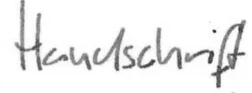

In [289]:
# You may need to convert the color.
img = cv2.cvtColor(cropped_images[1], cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img)
im_pil

In [290]:
pixel_values = processor(im_pil, return_tensors="pt").pixel_values.to(device)

In [291]:
with torch.no_grad():
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [292]:
generated_ids

tensor([[   2, 4539,   29, 7794, 2543,  479,    2]], device='cuda:0')

In [293]:
generated_text

'handschaft.'

In [294]:
pixel_values.shape

torch.Size([1, 3, 384, 384])

In [7]:
import os
import sys
import requests
from PIL import Image

In [8]:
# add paddleocr folder to python path
sys.path.insert(0,'./PaddleOCR')

In [9]:
from paddleocr import PaddleOCR, draw_ocr
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [10]:
def url_to_image(url):
    # Fetch the image from the URL
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Convert the image data to a NumPy array
        image_data = np.asarray(bytearray(response.content), dtype="uint8")
        
        # Decode the image data into an OpenCV image
        image = cv2.imdecode(image_data, cv2.IMREAD_GRAYSCALE) #cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE)
        
        return image
    else:
        raise Exception(f"Failed to download image. Status code: {response.status_code}")

In [45]:
#image = url_to_image("https://assets-global.website-files.com/62b2bd679b6d6fda81cfe7be/62b98cf6cb92c47d4aa3f288_Handschriften-p-500.webp")
image = url_to_image("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fpreview.redd.it%2F6hiua6igqi231.jpg%3Fwidth%3D1080%26crop%3Dsmart%26auto%3Dwebp%26s%3D11d27f374af5a53c10dd8d605443d2b5bf53f837&f=1&nofb=1&ipt=0782168ed0e003283e4f995680f23b12b7051a92fc423105d2c89819aed60b83&ipo=images")
image_path = './myimage.jpg'

#canvas_size = (512, 512)  # Example canvas size
#image = cv2.resize(image, canvas_size)

In [46]:
cv2.imwrite(image_path, image)
p_image = Image.open(image_path)

In [47]:
# Apply Gaussian blur
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

# Apply thresholding
_, binary_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_OTSU)
#b_inverted = cv2.bitwise_not(binary_image)

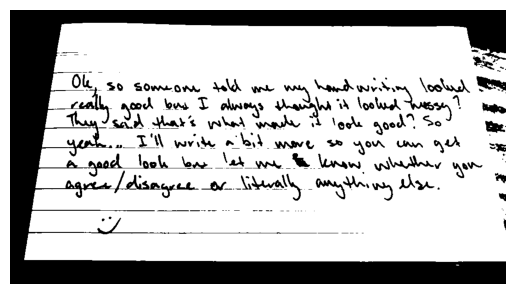

In [48]:
# Display the image using matplotlib
plt.imshow(cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [42]:
# Initialize the PaddleOCR model
ocr = PaddleOCR(use_angle_cls=True, 
                lang='en', #lang='german',char=True,
                #det_model_dir="./fce_model",#"./pse_model",
                det=True,        # Enable text detection
                rec=False,        # Disable text recognition
                drop_score=.5,
                #det_db_thresh=0.1,
                det_db_box_thresh=0.3,
                #det_db_unclip_ratio=4,
                det_algorithm='DB++',
                use_gpu=False,
               )

# Perform text detection and recognition
result = ocr.ocr(binary_image, rec=False,)

[2024/06/24 12:54:17] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB++', det_model_dir='/home/pico/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.3, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/pico/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_leng

In [43]:
bounding_boxes = result[0] #[box[0] for box in result[0] ]
len(bounding_boxes)

9

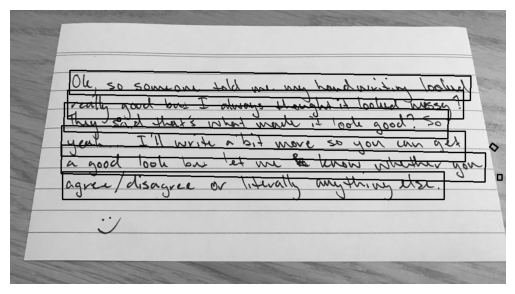

In [49]:
bounding_boxes_img = image.copy()

# Draw the bounding boxes on the image
#for box in bounding_boxes:
    #box = [[int(point[0]), int(point[1])] for point in box]
cv2.polylines(bounding_boxes_img, np.array(bounding_boxes, dtype=np.int32), isClosed=True, color=(0, 255, 0), thickness=2)

# Display the image with bounding boxes
plt.imshow(cv2.cvtColor(bounding_boxes_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [23]:
result[0]

[[[114.0, 353.0], [945.0, 353.0], [945.0, 413.0], [114.0, 413.0]],
 [[1061.0, 359.0], [1071.0, 359.0], [1071.0, 371.0], [1061.0, 371.0]],
 [[112.0, 295.0], [1035.0, 312.0], [1034.0, 375.0], [111.0, 357.0]],
 [[1050.0, 291.0], [1062.0, 300.0], [1055.0, 308.0], [1044.0, 299.0]],
 [[112.0, 253.0], [991.0, 265.0], [991.0, 331.0], [111.0, 319.0]],
 [[234.0, 236.0], [240.0, 236.0], [240.0, 243.0], [234.0, 243.0]],
 [[118.0, 203.0], [954.0, 218.0], [953.0, 281.0], [117.0, 266.0]],
 [[125.0, 176.0], [987.0, 176.0], [987.0, 238.0], [125.0, 238.0]],
 [[130.0, 133.0], [1003.0, 145.0], [1002.0, 198.0], [129.0, 185.0]]]

In [285]:
cropped_images = []

for box in bounding_boxes:
    bbox = np.array(box, dtype=np.int32)

    # Get the bounding rectangle (minimum area rectangle) from the polygonal points
    x, y, w, h = cv2.boundingRect(bbox)

    # Crop the region of interest (ROI) from the image
    cropped_image = image[y:y+h, x:x+w]
    
    # Append the cropped image to the list
    cropped_images.append(cropped_image)

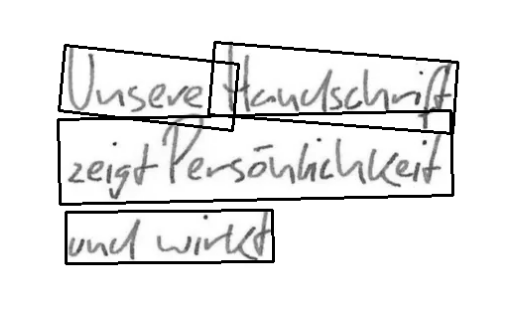

In [286]:
plt.imshow(cv2.cvtColor(bounding_boxes_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [287]:
def plot_cropped_images(cropped_images):
    """
    Function to plot a list of cropped images in separate cells of a Jupyter Notebook.
    
    Args:
    - cropped_images (list of numpy arrays): List containing cropped images (numpy arrays).
    """
    for i, cropped_image in enumerate(cropped_images):
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Cropped Image {i+1}')
        plt.show()

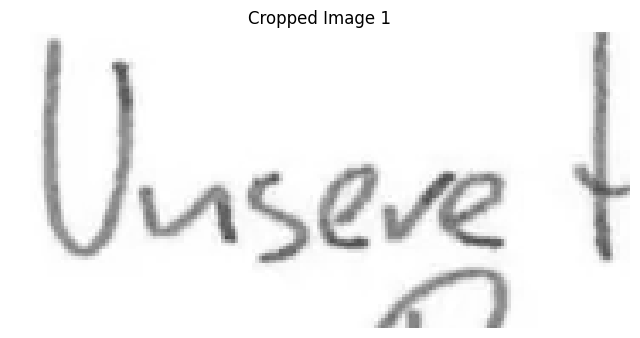

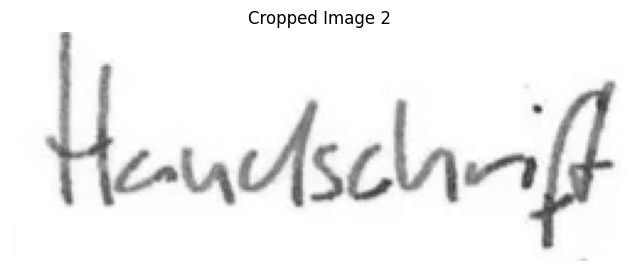

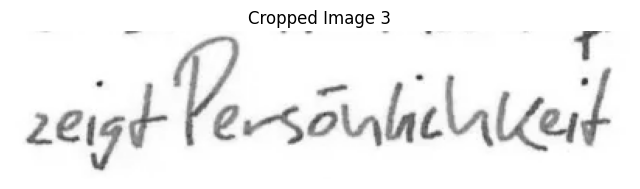

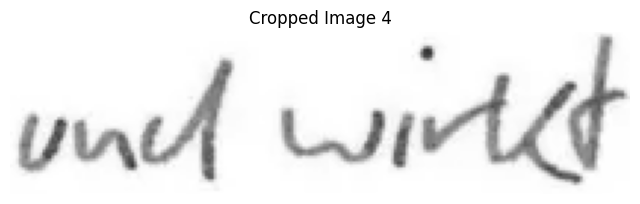

In [288]:
plot_cropped_images(cropped_images)

In [29]:
bounding_boxes[0]

[[114.0, 353.0], [945.0, 353.0], [945.0, 413.0], [114.0, 413.0]]

In [4]:
!pip install  paddlepaddle-gpu 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.9/758.9 MB 1.2 MB/s eta 0:00:00m eta 0:00:010:00:06


In [2]:
!pip uninstall -y opencv-python opencv-contrib-python opencv-python-headless paddleocrWordLevelDetection

Found existing installation: opencv-python 4.6.0.66
Uninstalling opencv-python-4.6.0.66:
  Successfully uninstalled opencv-python-4.6.0.66
Found existing installation: opencv-contrib-python 4.6.0.66
Uninstalling opencv-contrib-python-4.6.0.66:
  Successfully uninstalled opencv-contrib-python-4.6.0.66
Found existing installation: opencv-python-headless 4.10.0.84
Uninstalling opencv-python-headless-4.10.0.84:
  Successfully uninstalled opencv-python-headless-4.10.0.84
Found existing installation: paddleocrWordLevelDetection 2.6.1.0
Uninstalling paddleocrWordLevelDetection-2.6.1.0:
  Successfully uninstalled paddleocrWordLevelDetection-2.6.1.0


In [155]:
!pip uninstall -y  paddleocr

Found existing installation: paddleocr 2.8.0
Uninstalling paddleocr-2.8.0:
  Successfully uninstalled paddleocr-2.8.0


In [91]:
!pip install onnxruntime-gpu

  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl.metadata (12 kB)
  Using cached humanfriendly-10.0-py2.py3-none-any.whl.metadata (9.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 MB 3.1 MB/s eta 0:00:00m eta 0:00:010:00:01
Using cached coloredlogs-15.0.1-py2.py3-none-any.whl (46 kB)
Using cached humanfriendly-10.0-py2.py3-none-any.whl (86 kB)


In [36]:
cv2.polylines(bounding_boxes_img, np.array(box), isClosed=True, color=(0, 255, 0), thickness=2)

'4.6.0'

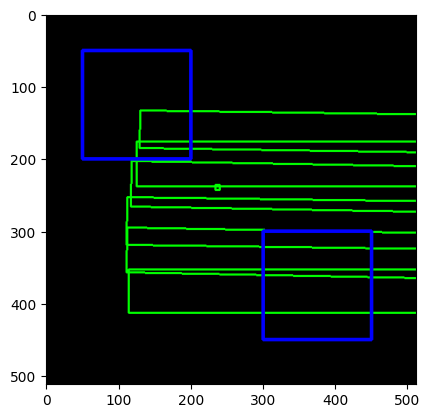

In [41]:
# Create a blank image
image = np.zeros((512, 512, 3), dtype=np.uint8)

# Define points for multiple polylines
points1 = np.array([[50, 50], [200, 50], [200, 200], [50, 200]], np.int32).reshape((-1, 1, 2))
points2 = np.array([[300, 300], [450, 300], [450, 450], [300, 450]], np.int32).reshape((-1, 1, 2))

# Draw the polylines on the image
cv2.polylines(bounding_boxes_img, [points1, points2], isClosed=True, color=(255, 0, 0), thickness=3)

# Display the image
plt.imshow(cv2.cvtColor(bounding_boxes_img, cv2.COLOR_BGR2RGB))
plt.show()